In [3]:
import pandas as pd
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize
from skimage.io import imread


# This function take access from google to use google drive.
# This function use if image folder is in google drive and program is run in google collab.

def google_drive_access():
    from google.colab import drive
    print("Required Google Drive Access. Go to this link the copy the code and paste it here ->  ")
    drive.mount('/content/drive')


# This  function select the Categories of the image which is in your folder to convert dataset.

def categories_Selection():
    Categories = ['person', 'dog', 'cat', 'car']
    print("Enter 1 to go with default Categories image classification of person, dog, cat, car  ->  \n")
    print("Enter 2 to give Categories Names used in the folder of Google Drive or in the computer image folder -> \n")

    while (True):
        n = int(input())
        if (n == 1 or n == 2):
            break
        print("\nWrong Input Type. Try again!\n")
    if (n == '2'):
        print("Enter Number of types of category image you want to Classify -> ")
        n = int(input())
        Categories = []
        print("Enter Categories : ", n, " Names.")
        for i in range(n):
            name = input()
            Categories.append(name)
        print("Please upload images from all categories ", n, " to Google Drive with the same name as the Categories.")
    return Categories


# You have to use directory_of_the_image_folder = /content . If the image folder are upload on to google collab.

# If the image folder are uploderd in the drive the use this as an example -> directory_of_the_image_folder = /content/drive/My Drive/Images

#  And you have to use directory_of_the_image_folder = C:\CSE475\CSE475_Project_Image_Recognition. If the image folder in the ccomputer.

# The path will be taken as an input.

# Under the image folder path all image categories have to be in a folder same as the categories name given in the program.

# For example -> If I have and foldet called "image"

# Which is in the path "C:\CSE475\CSE475_Project_Image_Recognition\image" then I have to store 'person', 'dog', 'cat','car'  under  this path.

# All these  categories must be in separate folder and the folder name must be same as categories name

# If user wants to use a Dataset th the dataset must be in  same folder as the python file.


def extract_data_from_an_image(categories_name):
    array_of_flat_data = []
    array_target = []
    directory_of_the_image_folder = input("Enter Folder Path which have the image folder ->  ")
    for i in categories_name:
        print("Category ", i, " is Loading ---> ")
        path = os.path.join(directory_of_the_image_folder, i)
        for image in os.listdir(path):
            image_array = imread(os.path.join(path, image))
            image_resized = resize(image_array, (150, 150, 3))
            array_of_flat_data.append(image_resized.flatten())
            array_target.append(categories_name.index(i))
        print("---> Category ", i, " is Loaded Successfully <---")
    x_flat_data = np.array(array_of_flat_data)
    y_target = np.array(array_target)
    dataset = pd.DataFrame(x_flat_data)
    dataset['Target'] = y_target
    return dataset, array_of_flat_data, array_target


# This function does all the process to select the dataset as user requires,

def dataset_Selection(n):
    n = int(n)
    if (n == 1):
        print("\nInput Type : ", 1)
        dataset_name = input(
            "Enter Dataset Name with the file type. Only csv file is applicable. Example -> CSE475_Image_Recognition_Dataset.csv  -> ")
        dataset = pd.read_csv(dataset_name)
        Categories = ['person', 'dog', 'cat', 'car']
        x_flat_data = dataset.iloc[:, :-1]
        y_target = dataset.iloc[:, -1]
        x_flat_data = x_flat_data.values.tolist()
        y_target = y_target.tolist()
        dataset = dataset.iloc[:, 1:]
        return dataset, Categories, x_flat_data, y_target
    elif (n == 2):
        print("\nInput Type : ", 2)
        google_drive_access()
        selected_Categories = categories_Selection()
        dataset, x_flat_data, y_target = extract_data_from_an_image(selected_Categories)
        return dataset, selected_Categories, x_flat_data, y_target
    elif (n == 3):
        print("\nInput Type : ", 3)
        selected_Categories = categories_Selection()
        dataset, x_flat_data, y_target = extract_data_from_an_image(selected_Categories)
        return dataset, selected_Categories, x_flat_data, y_target
    else:
        print("\nWrong Input Type. Try again!\n")


# This function split the dataset.

def dataset_split(dataset):
    x = dataset.iloc[:, :-1]
    y = dataset.iloc[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=40, stratify=y)
    print('The dataset splitted successfully')
    return x_train, x_test, y_train, y_test


# This function fits the SVM model.

def svc_model(x_train, y_train):
    param_grid_search = {'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.1, 1], 'kernel': ['rbf', 'poly']}
    svc = svm.SVC(probability=True)
    print("\nThe training of the model is started, please wait for while as it may take few minutes to complete")
    model = GridSearchCV(svc, param_grid_search)
    model.fit(x_train, y_train)
    print('\nThe Model is trained well with the given images')
    print(model.best_params_)
    return model, svc, param_grid_search


# This function predicts y.

def predict_Y(model, x_test):
    y_predict = model.predict(x_test)
    print("The predicted Data is :")
    print(y_predict)
    return y_predict


# This function takes an image URL from the user and predicts it.

def test_the_model_using_image_url(model, Categories):
    model = pickle.load(open('img_model.p', 'rb'))
    url = input('Enter the URL of the Image you want to check ->: ')
    image = imread(url)
    plt.imshow(image)
    plt.show()
    image_resize = resize(image, (150, 150, 3))
    image_flatten = [image_resize.flatten()]
    probability = model.predict_proba(image_flatten)
    for index, categories_name in enumerate(Categories):
        print(categories_name, " = ", probability[0][index] * 100, " % ")
    print("The predicted image is : " + Categories[model.predict(image_flatten)[0]])
    print("Is this image a ", Categories[model.predict(image_flatten)[0]], " ? ")
    print("Enter y if it is a ", Categories[model.predict(image_flatten)[0]])
    print("Enter n if it is not a ", Categories[model.predict(image_flatten)[0]])
    while (True):
        user_input = input()
        if (user_input == "y" or user_input == "n"):
            break
        print("\nWrong Input Type. Try again!\n")
    return user_input, image_flatten


# This function  improve the model performance using User feedback.

def improve_the_model_performance_using_user_feedback(user_input, Categories, x_flat_data, y_target, image_flatten,
                                                      model, svc, param_grid, n_store):
    if (user_input == 'n'):
        print("Please tell us what is the image to improve our model's performance.")
        for i in range(len(Categories)):
            print("Enter ", i, " if the image is -> ", Categories[i])
        user_input_about_image = int(input())
        while (user_input_about_image >= len(Categories) or user_input_about_image < 0):
            print("Given Number is not valid. The number must be between 1 to ", len(Categories), ". Try again!")
            user_input_about_image = int(input())
        print("Please wait for a while for the model to learn from this image :)")
        print("Our model is trying to learn from its mistake. "
              "Please wait for a while so that our model can learn properly.")
        new_x_flat_data = x_flat_data.copy()
        new_x_flat_data = pd.DataFrame(new_x_flat_data)
        if (n_store == 1):
            new_x_flat_data = new_x_flat_data.iloc[:, 1:]
        new_x_flat_data = new_x_flat_data.values.tolist()
        new_y_target = y_target.copy()
        new_y_target.append(user_input_about_image)
        new_x_flat_data.extend(image_flatten)
        new_y_target = np.array(new_y_target)
        new_x_flat_data = np.array(new_x_flat_data)
        new_dataset = pd.DataFrame(new_x_flat_data)
        new_dataset['Target'] = new_y_target
        new_model = GridSearchCV(svc, param_grid)
        x1 = new_dataset.iloc[:, :-1]
        y1 = new_dataset.iloc[:, -1]
        x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.30, random_state=44, stratify=y1)
        grid_new = {}
        for i in model.best_params_:
            grid_new[i] = [model.best_params_[i]]
        model1 = GridSearchCV(svc, grid_new)
        model1.fit(x_train1, y_train1)
        y_pred1 = model.predict(x_test1)
        print(f"The model is now {accuracy_score(y_pred1, y_test1) * 100}% accurate")
        pickle.dump(model1, open('img_model.p', 'wb'))
    print("Your feedback helpes us. Thank you.")


# Main function

if __name__ == '__main__':
    while True:
        print("Enter 1 to take Dataset from a csv file  ->\n")
        print("Enter 2 to take Dataset from your Google Colab using Google Drive image foldere  ->\n")
        print("Enter 3 to take Dataset from your Computer from an image foldere  ->\n")
        n = int(input("Enter Input Type -> "))
        n_store = n
        dataset, Categories, x_flat_data, y_target = dataset_Selection(n)
        print(dataset)
        if n == 1 or n == 2 or n == 3:
            break
    x_train, x_test, y_train, y_test = dataset_split(dataset)
    model, svc, param_grid_search = svc_model(x_train, y_train)
    y_predict = predict_Y(model, x_test)
    print("\nThe predict Y is:")
    print(y_predict)
    print("\nThe actual Y is:")
    print(np.array(y_test))
    print("\nAcuracy of the SVM model is ", accuracy_score(y_predict, y_test) * 100, " % ")
    pickle.dump(model, open('img_model.p', 'wb'))


Enter 1 to take Dataset from a csv file  ->

Enter 2 to take Dataset from your Google Colab using Google Drive image foldere  ->

Enter 3 to take Dataset from your Computer from an image foldere  ->

Enter Input Type -> 1

Input Type :  1
Enter Dataset Name with the file type. Only csv file is applicable. Example -> CSE475_Image_Recognition_Dataset.csv  -> CSE475_Project_Image_Recognition.csv
            0         1         2         3         4         5         6  \
0    0.215686  0.274510  0.439216  0.219608  0.274510  0.439299  0.219608   
1    0.466686  0.479601  0.435784  0.557640  0.568489  0.547370  0.557697   
2    0.011765  0.011765  0.011765  0.011765  0.011765  0.011765  0.011765   
3    0.508418  0.374189  0.264385  0.471655  0.350322  0.240989  0.459974   
4    0.411765  0.329412  0.317647  0.415686  0.329412  0.321569  0.415686   
..        ...       ...       ...       ...       ...       ...       ...   
203  0.070588  0.070588  0.070588  0.070588  0.070588  0.070588  

Enter the URL of the Image you want to check ->: https://thumbor.forbes.com/thumbor/fit-in/1200x0/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fimageserve%2F5d35eacaf1176b0008974b54%2F0x0.jpg%3FcropX1%3D790%26cropX2%3D5350%26cropY1%3D784%26cropY2%3D3349


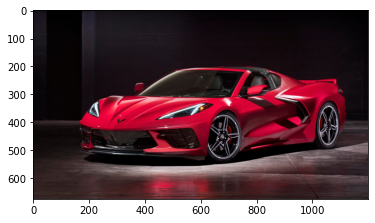

person  =  10.277311138108445  % 
dog  =  20.248189229545126  % 
cat  =  55.13828151959089  % 
car  =  14.336218112755494  % 
The predicted image is : cat
Is this image a  cat  ? 
Enter y if it is a  cat
Enter n if it is not a  cat
n
Please tell us what is the image to improve our model's performance.
Enter  0  if the image is ->  person
Enter  1  if the image is ->  dog
Enter  2  if the image is ->  cat
Enter  3  if the image is ->  car
3
Please wait for a while for the model to learn from this image :)
Our model is trying to learn from its mistake. Please wait for a while so that our model can learn properly.
The model is now 87.3015873015873% accurate
Your feedback helpes us. Thank you.

Do you want to recognize an image again?

Enter 1 to recognize an image again.

Enter 2 to exit the program.
Enter Input Type -> 1
Enter the URL of the Image you want to check ->: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQW2M-KcXf4PmnQG8GQxFFL94btd7u1zGhy-Q&usqp=CAU


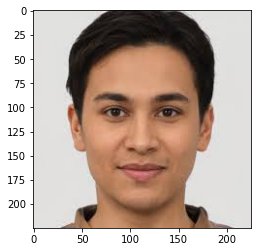

person  =  53.81032001923764  % 
dog  =  35.35353566439311  % 
cat  =  9.620313374989378  % 
car  =  1.215830941379883  % 
The predicted image is : person
Is this image a  person  ? 
Enter y if it is a  person
Enter n if it is not a  person
y
Your feedback helpes us. Thank you.

Do you want to recognize an image again?

Enter 1 to recognize an image again.

Enter 2 to exit the program.
Enter Input Type -> 1
Enter the URL of the Image you want to check ->: https://images.financialexpress.com/2020/04/most-expensive-cars-in-the-world-bugatti-centodieci.jpg?w=800&h=450&imflag=true


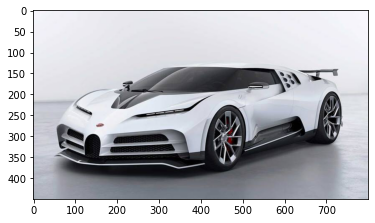

person  =  4.581646262595726  % 
dog  =  19.212222378559822  % 
cat  =  5.266253784641509  % 
car  =  70.93987757420292  % 
The predicted image is : car
Is this image a  car  ? 
Enter y if it is a  car
Enter n if it is not a  car
y
Your feedback helpes us. Thank you.

Do you want to recognize an image again?

Enter 1 to recognize an image again.

Enter 2 to exit the program.
Enter Input Type -> 1
Enter the URL of the Image you want to check ->: https://media.istockphoto.com/photos/grey-stripped-mixedbreed-cat-sitting-isolated-on-white-picture-id1217828258?b=1&k=20&m=1217828258&s=170667a&w=0&h=jVuou3wnJ1x7eLf0iWS53BvA5ZOyROTBfiTM3tPhD4g=


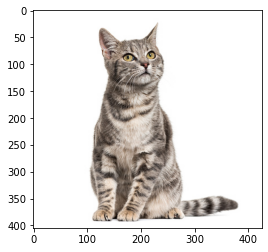

person  =  3.23822820959261  % 
dog  =  24.060619270322995  % 
cat  =  63.41402758775207  % 
car  =  9.287124932332294  % 
The predicted image is : cat
Is this image a  cat  ? 
Enter y if it is a  cat
Enter n if it is not a  cat
y
Your feedback helpes us. Thank you.

Do you want to recognize an image again?

Enter 1 to recognize an image again.

Enter 2 to exit the program.
Enter Input Type -> 1
Enter the URL of the Image you want to check ->: https://jngnposwzs-flywheel.netdna-ssl.com/wp-content/uploads/2019/05/Transparent-OrangeWhiteCat-764x1024.png


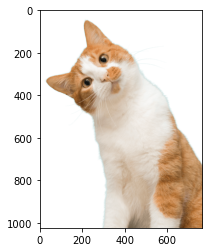

person  =  1.5287483142394402  % 
dog  =  50.392975787123895  % 
cat  =  46.757401124599035  % 
car  =  1.3208747740376348  % 
The predicted image is : cat
Is this image a  cat  ? 
Enter y if it is a  cat
Enter n if it is not a  cat
y
Your feedback helpes us. Thank you.

Do you want to recognize an image again?

Enter 1 to recognize an image again.

Enter 2 to exit the program.
Enter Input Type -> 1
Enter the URL of the Image you want to check ->: https://cdn.dnaindia.com/sites/default/files/styles/full/public/2017/11/04/622378-cat.jpg


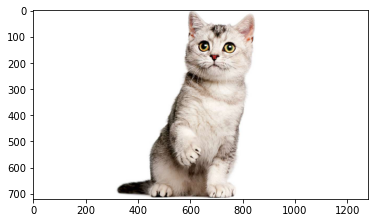

person  =  2.3411354655205074  % 
dog  =  14.124396000302802  % 
cat  =  75.69635270173455  % 
car  =  7.838115832442128  % 
The predicted image is : cat
Is this image a  cat  ? 
Enter y if it is a  cat
Enter n if it is not a  cat
y
Your feedback helpes us. Thank you.

Do you want to recognize an image again?

Enter 1 to recognize an image again.

Enter 2 to exit the program.
Enter Input Type -> 1
Enter the URL of the Image you want to check ->: https://images.unsplash.com/photo-1543466835-00a7907e9de1?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8YmVhZ2xlfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&w=1000&q=80


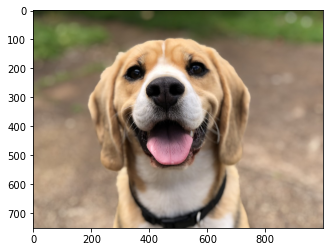

person  =  23.99378529733015  % 
dog  =  55.88963785001035  % 
cat  =  18.899233213846152  % 
car  =  1.2173436388133378  % 
The predicted image is : dog
Is this image a  dog  ? 
Enter y if it is a  dog
Enter n if it is not a  dog
y
Your feedback helpes us. Thank you.

Do you want to recognize an image again?

Enter 1 to recognize an image again.

Enter 2 to exit the program.
Enter Input Type -> 2
The program Ended. Thank you.


In [4]:
    # This cell takes URLs as many times as the user wants to do Image Recognition.
    while True:
        user_input, image_flatten = test_the_model_using_image_url(model, Categories)
        improve_the_model_performance_using_user_feedback(user_input, Categories, x_flat_data, y_target, image_flatten,
                                                          model,
                                                          svc, param_grid_search, n_store)
        print("\nDo you want to recognize an image again?")
        print("\nEnter 1 to recognize an image again.")
        print("\nEnter 2 to exit the program.")
        n = int(input("Enter Input Type -> "))
        if n == 2:
            break
    print("The program Ended. Thank you.")

# Image URL you can use to Recognize the Image ->


https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQW2M-KcXf4PmnQG8GQxFFL94btd7u1zGhy-Q&usqp=CAU
        
https://images.financialexpress.com/2020/04/most-expensive-cars-in-the-world-bugatti-centodieci.jpg?w=800&h=450&imflag=true
    
https://media.istockphoto.com/photos/grey-stripped-mixedbreed-cat-sitting-isolated-on-white-picture-id1217828258?b=1&k=20&m=1217828258&s=170667a&w=0&h=jVuou3wnJ1x7eLf0iWS53BvA5ZOyROTBfiTM3tPhD4g=
        
https://jngnposwzs-flywheel.netdna-ssl.com/wp-content/uploads/2019/05/Transparent-OrangeWhiteCat-764x1024.png
    
https://cdn.dnaindia.com/sites/default/files/styles/full/public/2017/11/04/622378-cat.jpg
    
    
https://images.unsplash.com/photo-1543466835-00a7907e9de1?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8YmVhZ2xlfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&w=1000&q=80

# Dataset link below >>

https://drive.google.com/file/d/1jBHWITfA4qUrRyUZ6RfSrPoase0Ot4z2/view?usp=sharing

# Use this link as your Image Folder for this project >>

https://drive.google.com/drive/folders/1JwDjp0e7H_YNChxjs0Dm8jjssrRgJMdy?usp=sharing